In [5]:
import math
import sys
import time

import h5py
import matplotlib.pyplot as plt
import mlflow
import numpy as np
from numpy.random import choice
import torch
import torch.nn as nn
import torch.distributed as dist
from torch.cuda.amp import autocast
from torch.distributed import get_world_size
from torch.optim import SGD, Optimizer, Adam
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from tqdm.auto import tqdm as tq

from craterdetection.detection.model import DeepMoon
from craterdetection.detection.training import CraterDataset, BCEDiceLoss, RAdam, f_score

In [6]:
mlflow.set_tracking_uri("http://localhost:5000/")
mlflow.set_experiment("crater-detection")

In [7]:
class CraterInstanceDataset(Dataset):
    def __init__(self,
                 file_path,
                 group,
                 cuda=True
                 ):
        self.file_path = file_path
        self.group = group
        self.dataset = None
        self.cuda = cuda

    def __getitem__(self, idx):
        if self.dataset is None:
            self.dataset = h5py.File(self.file_path, 'r')

        images = self.dataset[self.group]["images"][idx]
        mask = self.dataset[self.group]["masks"][idx]

        images = (images / np.max(images, axis=(1, 2))[..., None, None]) * 255

        obj_ids = np.unique(mask)[1:]
        masks = mask == obj_ids[:, None, None]

        num_objs = len(obj_ids)

        boxes = np.empty((num_objs, 4), int)
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes[i] = np.array([xmin, ymin, xmax, ymax])

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area_filter = area > 4

        masks, obj_ids, boxes, area = map(lambda x: x[area_filter], (masks, obj_ids, boxes, area))

        num_objs = len(obj_ids)

        images = torch.as_tensor(images, dtype=torch.float32)

        boxes = torch.as_tensor(boxes, dtype=torch.int64)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        area = torch.as_tensor(area, dtype=torch.float32)
        image_id = torch.tensor([idx])

        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        return images, target

    def random(self):
        return self.__getitem__(
            np.random.randint(0, len(self))
        )

    def __len__(self):
        with h5py.File(self.file_path, 'r') as f:
            return len(f[self.group]['images'])

    def __del__(self):
        if self.dataset is not None:
            self.dataset.close()

def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = CraterInstanceDataset("../data/dataset_instanced.h5", "training")
train_loader = DataLoader(train_dataset, batch_size=2, num_workers=0, collate_fn=collate_fn, shuffle=True)

validation_dataset = CraterInstanceDataset("../data/dataset_instanced.h5", "validation")
validation_loader = DataLoader(validation_dataset, batch_size=4, num_workers=0, collate_fn=collate_fn)

test_dataset = CraterInstanceDataset("../data/dataset_instanced.h5", "test")
test_loader = DataLoader(test_dataset, batch_size=6, num_workers=0, collate_fn=collate_fn, shuffle=True)

In [20]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

model = get_model_instance_segmentation(2)
print("")

In [21]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0001, momentum=0.5, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu):

In [22]:
num_epochs = 3

with mlflow.start_run(run_name="MaskRCNN Test"):

    mlflow.log_param('optimizer', type(optimizer).__name__)

    train_loss_list = []
    valid_loss_list = []
    dice_score_list = []

    for e in range(1, num_epochs+1):
        print(f'\n-----Epoch {e} started-----\n')

        since = time.time()

        train_loss, valid_loss, dice_score = 0, 0, 0

        model.train()

        bar = tq(train_loader, desc=f"Training [{e}]", postfix={"train_loss": 0.0})
        for batch, (images, targets) in enumerate(bar, 1):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)

            losses = sum(loss for loss in loss_dict.values())

            loss_value = losses

            if not math.isfinite(loss_value):
                print("Loss is {}, stopping training".format(loss_value))
                print(loss_dict)
                sys.exit(1)

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            if lr_scheduler is not None:
               lr_scheduler.step()
            bar.set_postfix(ordered_dict={"train_loss": losses.item()})

            train_loss += losses.item()

        train_loss /= len(train_loader)

        time_elapsed = time.time() - since
        print(
            f"\nSummary:\n",
            f"\tEpoch: {e}/{num_epochs}\n",
            f"\tAverage train loss: {train_loss}\n",
            f"\tDuration: {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s"
        )
        print(f'-----Epoch {e} finished.-----\n')


-----Epoch 1 started-----

Loss is nan, stopping training
{'loss_classifier': tensor(nan, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(nan, device='cuda:0', grad_fn=<DivBackward0>), 'loss_mask': tensor(2.3560e+13, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_objectness': tensor(nan, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(nan, device='cuda:0', grad_fn=<DivBackward0>)}


Training [1]:   0%|          | 0/5000 [00:00<?, ?it/s, train_loss=0]

SystemExit: 1

C:\Users\w_dop\miniconda3\envs\crater-detection\lib\site-packages\IPython\core\interactiveshell.py:3445: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


IndexError: index 15 is out of bounds for dimension 0 with size 0

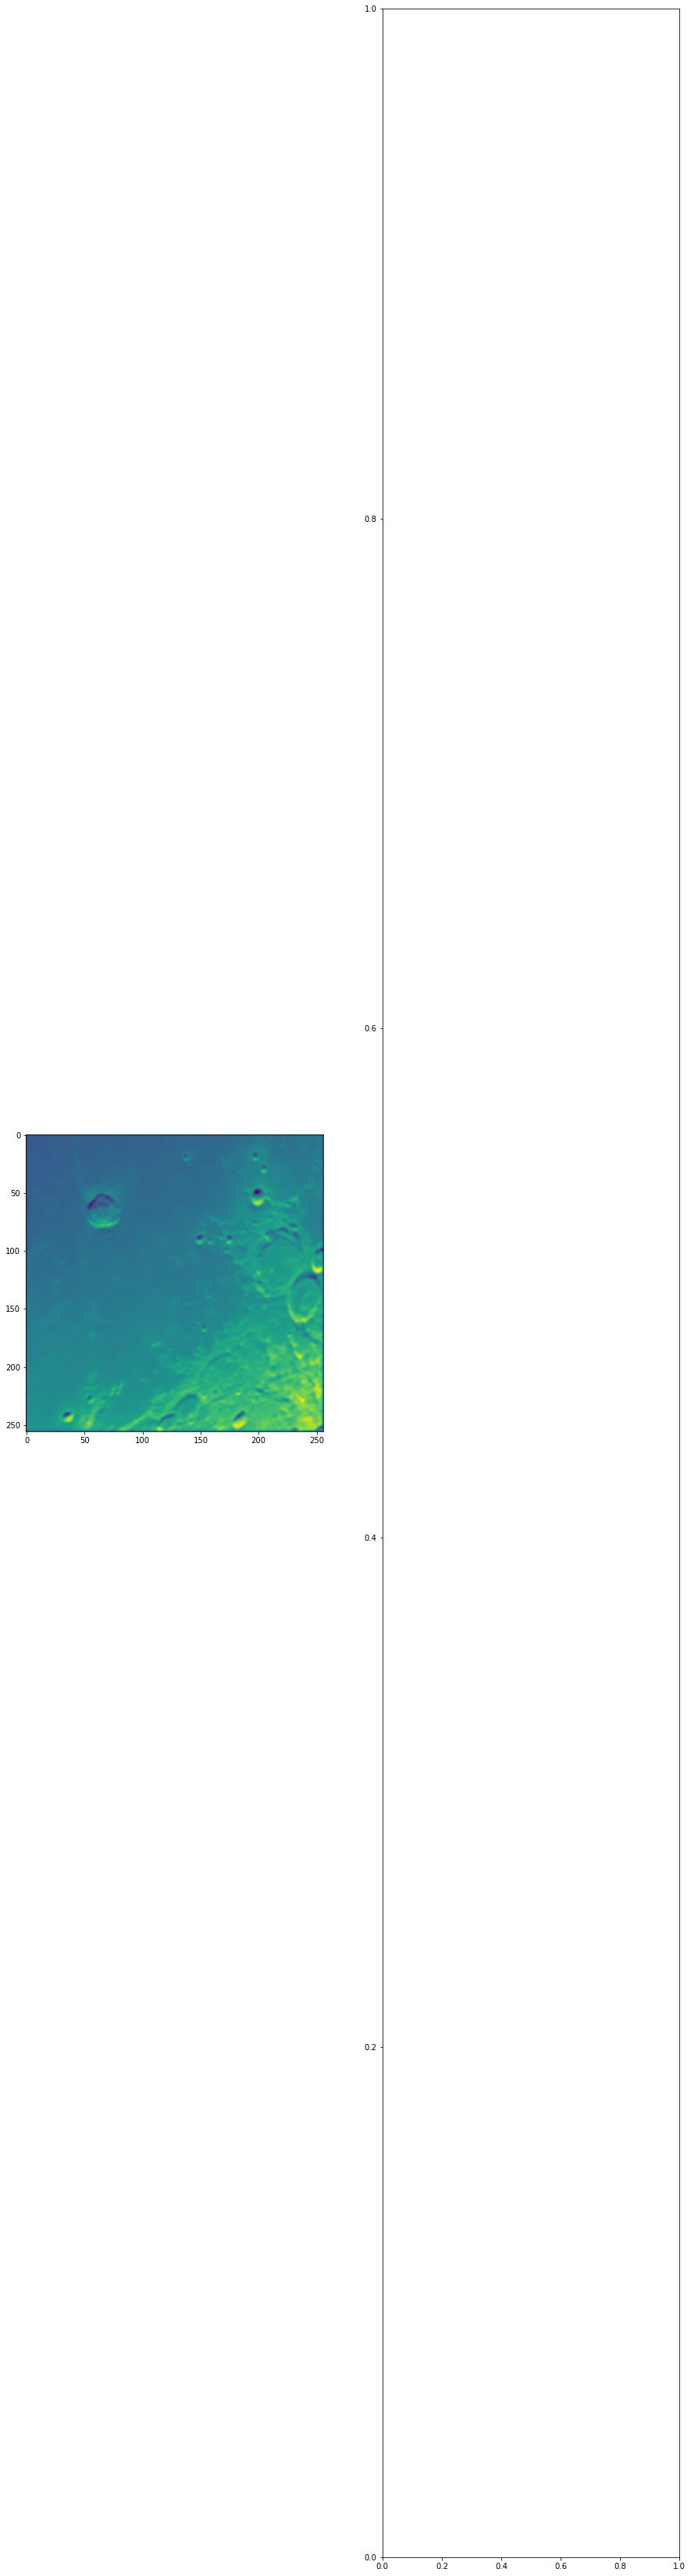

In [23]:
model.eval()

with torch.no_grad():
    images, targets = next(iter(test_loader))
    images = list(image.cuda() for image in images)
    targets = [{k: v.cuda() for k, v in t.items()} for t in targets]

    out = model(images)

fig, axes = plt.subplots(1, 2, figsize=(15, 60))

axes[0].imshow(images[0][0].cpu().numpy())
axes[1].imshow(out[0]["masks"][15, 0].cpu().numpy())